# Harrison Oates 5508 Assignment 2
CITS5508 - Harrison Oates (22966832)

## 1.0 Breast Cancer Wisconcin Data Loading
---

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

data = load_breast_cancer()
X = data.data

y = data.target
print(X.shape)
print(y.shape)

(569, 30)
(569,)


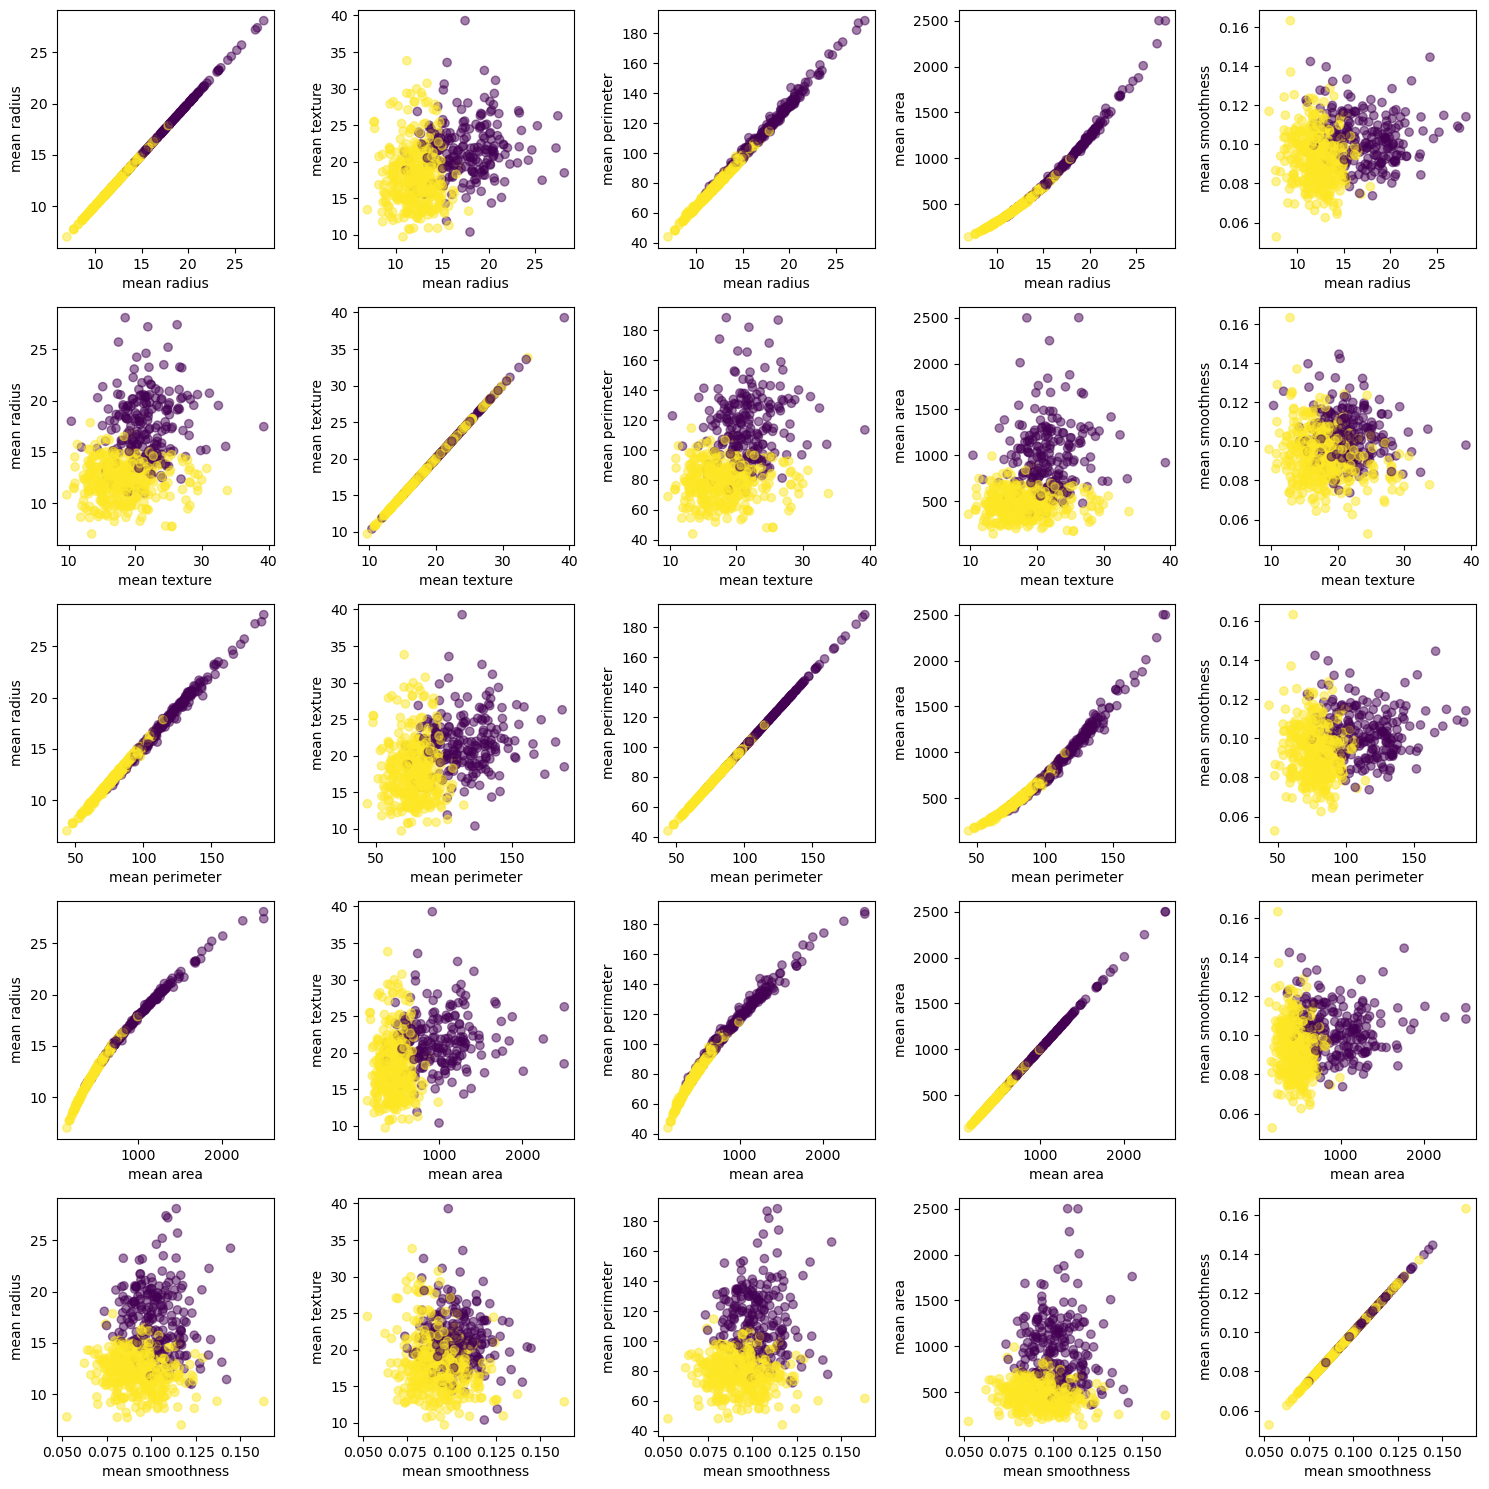

In [12]:


data_df = pd.DataFrame(data.data, columns=data.feature_names)
data_df['target'] = data.target

# Select a subset of features for visualization
selected_features = data_df.columns[:5]

# Create scatter plots for each pair of features
fig, ax = plt.subplots(len(selected_features), len(selected_features), figsize=(15, 15))

for i, feature_i in enumerate(selected_features):
    for j, feature_j in enumerate(selected_features):
        ax[i, j].scatter(data_df[feature_i], data_df[feature_j], c=data_df['target'], alpha=0.5)
        ax[i, j].set_xlabel(feature_i)
        ax[i, j].set_ylabel(feature_j)

plt.tight_layout()
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

clf1 = DecisionTreeClassifier(random_state=123)
clf1.fit(X_train, y_train)
y_train_pred1 = clf1.predict(X_train)
y_test_pred1 = clf1.predict(X_test)

train_acc1 = accuracy_score(y_train, y_train_pred1)
test_acc1 = accuracy_score(y_test, y_test_pred1)

print(f'Training accuracy: {train_acc1}')
print(f'Test accuracy: {test_acc1}')

Training accuracy: 1.0
Test accuracy: 0.9418604651162791
